In [1]:
# https://github.com/microsoft/ProDA/blob/main/data/gta5_dataset.py

In [2]:
import os
import torch
import numpy as np
import logging

from PIL import Image

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [4]:
"""Base segmentation dataset"""
import os
import random
import numpy as np
import torchvision

from PIL import Image, ImageOps, ImageFilter
from segmentron.config import cfg


class SegmentationDataset(object):
    """Segmentation Base Dataset"""

    def __init__(self, root, split, mode, transform, base_size=520, crop_size=480):
        super(SegmentationDataset, self).__init__()
        self.root = os.path.join(cfg.ROOT_PATH, root)
        self.transform = transform
        self.split = split
        self.mode = mode if mode is not None else split
        self.base_size = base_size
        self.crop_size = self.to_tuple(crop_size)
        self.color_jitter = self._get_color_jitter()

    def to_tuple(self, size):
        if isinstance(size, (list, tuple)):
            return tuple(size)
        elif isinstance(size, (int, float)):
            return tuple((size, size))
        else:
            raise ValueError('Unsupport datatype: {}'.format(type(size)))

    def _get_color_jitter(self):
        color_jitter = cfg.AUG.COLOR_JITTER
        if color_jitter is None:
            return None
        if isinstance(color_jitter, (list, tuple)):
            # color jitter should be a 3-tuple/list if spec brightness/contrast/saturation
            # or 4 if also augmenting hue
            assert len(color_jitter) in (3, 4)
        else:
            # if it's a scalar, duplicate for brightness, contrast, and saturation, no hue
            color_jitter = (float(color_jitter),) * 3
        return torchvision.transforms.ColorJitter(*color_jitter)

    def _val_sync_transform(self, img, mask):
        outsize = self.crop_size
        short_size = min(outsize)
        w, h = img.size
        if w > h:
            oh = short_size
            ow = int(1.0 * w * oh / h)
        else:
            ow = short_size
            oh = int(1.0 * h * ow / w)
        img = img.resize((ow, oh), Image.BILINEAR)
        mask = mask.resize((ow, oh), Image.NEAREST)
        # center crop
        w, h = img.size
        x1 = int(round((w - outsize[1]) / 2.))
        y1 = int(round((h - outsize[0]) / 2.))
        img = img.crop((x1, y1, x1 + outsize[1], y1 + outsize[0]))
        mask = mask.crop((x1, y1, x1 + outsize[1], y1 + outsize[0]))

        # final transform
        img, mask = self._img_transform(img), self._mask_transform(mask)
        return img, mask

    def _sync_transform(self, img, mask):
        # random mirror
        if cfg.AUG.MIRROR and random.random() < 0.5:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        crop_size = self.crop_size
        # random scale (short edge)
        short_size = random.randint(int(self.base_size * 0.5), int(self.base_size * 2.0))
        w, h = img.size
        if h > w:
            ow = short_size
            oh = int(1.0 * h * ow / w)
        else:
            oh = short_size
            ow = int(1.0 * w * oh / h)
        img = img.resize((ow, oh), Image.BILINEAR)
        mask = mask.resize((ow, oh), Image.NEAREST)
        # pad crop
        if short_size < min(crop_size):
            padh = crop_size[0] - oh if oh < crop_size[0] else 0
            padw = crop_size[1] - ow if ow < crop_size[1] else 0
            img = ImageOps.expand(img, border=(0, 0, padw, padh), fill=0)
            mask = ImageOps.expand(mask, border=(0, 0, padw, padh), fill=-1)
        # random crop crop_size
        w, h = img.size
        x1 = random.randint(0, w - crop_size[1])
        y1 = random.randint(0, h - crop_size[0])
        img = img.crop((x1, y1, x1 + crop_size[1], y1 + crop_size[0]))
        mask = mask.crop((x1, y1, x1 + crop_size[1], y1 + crop_size[0]))
        # gaussian blur as in PSP
        if cfg.AUG.BLUR_PROB > 0 and random.random() < cfg.AUG.BLUR_PROB:
            radius = cfg.AUG.BLUR_RADIUS if cfg.AUG.BLUR_RADIUS > 0 else random.random()
            img = img.filter(ImageFilter.GaussianBlur(radius=radius))
        # color jitter
        if self.color_jitter:
            img = self.color_jitter(img)
        # final transform
        img, mask = self._img_transform(img), self._mask_transform(mask)
        return img, mask

    def _img_transform(self, img):
        return np.array(img)

    def _mask_transform(self, mask):
        return np.array(mask).astype('int32')

    @property
    def num_class(self):
        """Number of categories."""
        return self.NUM_CLASS

    @property
    def pred_offset(self):
        return 0


In [97]:
class CitySegmentation(SegmentationDataset):
    """Cityscapes Semantic Segmentation Dataset.

    Parameters
    ----------
    root : string
        Path to Cityscapes folder. Default is './datasets/cityscapes'
    split: string
        'train', 'val' or 'test'
    transform : callable, optional
        A function that transforms the image
    Examples
    --------
    >>> from torchvision import transforms
    >>> import torch.utils.data as data
    >>> # Transforms for Normalization
    >>> input_transform = transforms.Compose([
    >>>     transforms.ToTensor(),
    >>>     transforms.Normalize((.485, .456, .406), (.229, .224, .225)),
    >>> ])
    >>> # Create Dataset
    >>> trainset = CitySegmentation(split='train', transform=input_transform)
    >>> # Create Training Loader
    >>> train_data = data.DataLoader(
    >>>     trainset, 4, shuffle=True,
    >>>     num_workers=4)
    """
    BASE_DIR = 'citys'
    NUM_CLASS = 19

    def __init__(self, root='/data/datasets', split='train', mode=None, transform=None, **kwargs):
        super(CitySegmentation, self).__init__(root, split, mode, transform, **kwargs)
        self.root = os.path.join(root, self.BASE_DIR)
        assert os.path.exists(self.root), "Please put dataset in {SEG_ROOT}/datasets/cityscapes"
        self.images, self.mask_paths = _get_city_pairs(self.root, self.split)
        assert (len(self.images) == len(self.mask_paths))
        if len(self.images) == 0:
            raise RuntimeError("Found 0 images in subfolders of:" + root + "\n")
        self.valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22,
                              23, 24, 25, 26, 27, 28, 31, 32, 33]
        self._key = np.array([-1, -1, -1, -1, -1, -1,
                              -1, -1, 0, 1, -1, -1,
                              2, 3, 4, -1, -1, -1,
                              5, -1, 6, 7, 8, 9,
                              10, 11, 12, 13, 14, 15,
                              -1, -1, 16, 17, 18])
        self._mapping = np.array(range(-1, len(self._key) - 1)).astype('int32')

    def _class_to_index(self, mask):
        # assert the value
        values = np.unique(mask)
        for value in values:
            assert (value in self._mapping)
        index = np.digitize(mask.ravel(), self._mapping, right=True)
        return self._key[index].reshape(mask.shape)

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        if self.mode == 'test':
            if self.transform is not None:
                img = self.transform(img)
            return img, os.path.basename(self.images[index])
        mask = Image.open(self.mask_paths[index])
        # synchrosized transform
        if self.mode == 'train':
            img, mask = self._sync_transform(img, mask)
        elif self.mode == 'val':
            img, mask = self._val_sync_transform(img, mask)
        else:
            assert self.mode == 'testval'
            img, mask = self._img_transform(img), self._mask_transform(mask)
        # general resize, normalize and toTensor
        if self.transform is not None:
            img = self.transform(img)
        return img, mask, os.path.basename(self.images[index])

    def _mask_transform(self, mask):
        target = self._class_to_index(np.array(mask).astype('int32'))
        return torch.LongTensor(np.array(target).astype('int32'))

    def __len__(self):
        return len(self.images)

    @property
    def pred_offset(self):
        return 0

    @property
    def classes(self):
        """Category names."""
        return ('road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
                'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car',
                'truck', 'bus', 'train', 'motorcycle', 'bicycle')


def _get_city_pairs(folder, split='train'):
    def get_path_pairs(img_folder, mask_folder):
        img_paths = []
        mask_paths = []
        for root, _, files in os.walk(img_folder):
            for filename in files:
                if filename.startswith('._'):
                    continue
                if filename.endswith('.png'):
                    imgpath = os.path.join(root, filename)
                    foldername = os.path.basename(os.path.dirname(imgpath))
                    maskname = filename.replace('leftImg8bit', 'gtFine_labelIds')
                    maskpath = os.path.join(mask_folder, foldername, maskname)
                    if os.path.isfile(imgpath) and os.path.isfile(maskpath):
                        img_paths.append(imgpath)
                        mask_paths.append(maskpath)
                    else:
                        logging.info('cannot find the mask or image:', imgpath, maskpath)
        logging.info('Found {} images in the folder {}'.format(len(img_paths), img_folder))
        return img_paths, mask_paths

    if split in ('train', 'val'):
        img_folder = os.path.join(folder, 'leftImg8bit/' + split)
        mask_folder = os.path.join(folder, 'gtFine/' + split)
        img_paths, mask_paths = get_path_pairs(img_folder, mask_folder)
        return img_paths, mask_paths
    else:
        assert split == 'trainval'
        logging.info('trainval set')
        train_img_folder = os.path.join(folder, 'leftImg8bit/train')
        train_mask_folder = os.path.join(folder, 'gtFine/train')
        val_img_folder = os.path.join(folder, 'leftImg8bit/val')
        val_mask_folder = os.path.join(folder, 'gtFine/val')
        train_img_paths, train_mask_paths = get_path_pairs(train_img_folder, train_mask_folder)
        val_img_paths, val_mask_paths = get_path_pairs(val_img_folder, val_mask_folder)
        img_paths = train_img_paths + val_img_paths
        mask_paths = train_mask_paths + val_mask_paths
    return img_paths, mask_paths


In [111]:
import scipy.io as io
    
class GTASegmentation(SegmentationDataset):
    BASE_DIR = 'gta'
    NUM_CLASS = 19

    colors = [  # [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]
    
    void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, 34, -1]
    valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33,]
    ignore_index = 0
    class_map = dict(zip(valid_classes, range(19)))

    label_colours = dict(zip(range(NUM_CLASS), colors))

    def __init__(self, root='/data/datasets', split='train', mode=None, transform=None, **kwargs):
        super(GTASegmentation, self).__init__(root, split, mode, transform, **kwargs)
        
        self.mean = [0.0, 0.0, 0.0]
        self.img_size = (2048, 1024)
        
        self.root = os.path.join(root, self.BASE_DIR)
        print(self.root)
        assert os.path.exists(self.root), "Please put dataset in {SEG_ROOT}/datasets/gta"
        self.images, self.mask_paths = _get_gta_pairs(self.root, self.split)
        assert (len(self.images) == len(self.mask_paths))
        if len(self.images) == 0:
            raise RuntimeError("Found 0 images in subfolders of:" + root + "\n")

        self.valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22,
                              23, 24, 25, 26, 27, 28, 31, 32, 33]
        self._key = np.array([-1, -1, -1, -1, -1, -1,
                              -1, -1, 0, 1, -1, -1,
                              2, 3, 4, -1, -1, -1,
                              5, -1, 6, 7, 8, 9,
                              10, 11, 12, 13, 14, 15,
                              -1, -1, 16, 17, 18])
        self._mapping = np.array(range(-1, len(self._key) - 1)).astype('int32')

    def _class_to_index(self, mask):
        # assert the value
        values = np.unique(mask)
        for value in values:
            assert (value in self._mapping)
        index = np.digitize(mask.ravel(), self._mapping, right=True)
        return self._key[index].reshape(mask.shape)

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        img = img.resize(self.img_size, Image.BILINEAR)
        
        if self.mode == 'test':
            if self.transform is not None:
                img = self.transform(img)
            return img, os.path.basename(self.images[index])
        mask = Image.open(self.mask_paths[index])
        mask = mask.resize(self.img_size, Image.NEAREST)

        # synchrosized transform
        if self.mode == 'train':
            img, mask = self._sync_transform(img, mask)
        elif self.mode == 'val':
            img, mask = self._val_sync_transform(img, mask)
        else:
            assert self.mode == 'testval'
            img, mask = self._img_transform(img), self._mask_transform(mask)
        # general resize, normalize and toTensor
        if self.transform is not None:
            img = self.transform(img)
        return img, mask, os.path.basename(self.images[index])

    def _mask_transform(self, mask):
        target = self._class_to_index(np.array(mask).astype('int32'))
        return torch.LongTensor(np.array(target).astype('int32'))
    
    def _encode_segmap(self, lbl):
        for _i in self.void_classes:
            lbl[lbl == _i] = self.ignore_index
        for _i in self.valid_classes:
            lbl[lbl == _i] = self.class_map[_i]
        return lbl
    
    def transform(self, img, lbl):
        """transform

        img, lbl
        """
        img = np.array(img)
        # img = img[:, :, ::-1] # RGB -> BGR
        img = img.astype(np.float64)
        img -= self.mean
        img = img.astype(float) / 255.0
        img = img.transpose(2, 0, 1)

        classes = np.unique(lbl)
        lbl = np.array(lbl)
        lbl = lbl.astype(float)
        # lbl = m.imresize(lbl, self.img_size, "nearest", mode='F')
        lbl = lbl.astype(int)
        
        if not np.all(classes == np.unique(lbl)):
            print("WARN: resizing labels yielded fewer classes")    #TODO: compare the original and processed ones

        if not np.all(np.unique(lbl[lbl != self.ignore_index]) < self.NUM_CLASS): 
            print("after det", classes, np.unique(lbl))
            raise ValueError("Segmentation map contained invalid class values")
        
        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()

        return img, lbl

    def __len__(self):
        return len(self.images)

    @property
    def pred_offset(self):
        return 0

    @property
    def classes(self):
        """Category names."""
        return ('road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
                'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car',
                'truck', 'bus', 'train', 'motorcycle', 'bicycle')


def _get_gta_pairs(folder, split='train'):
    def get_path_pairs(img_folder, mask_folder):
        img_paths = []
        mask_paths = []
        for root, _, files in os.walk(img_folder):
            for filename in files:
                if filename.endswith('.png'):
                    imgpath = os.path.join(root, filename)
                    foldername = os.path.basename(os.path.dirname(imgpath))
                    maskpath = os.path.join(mask_folder, '', filename)
                    if os.path.isfile(imgpath) and os.path.isfile(maskpath):
                        img_paths.append(imgpath)
                        mask_paths.append(maskpath)
                    else:
                        logging.info('cannot find the mask or image:', imgpath, maskpath)
        logging.info('Found {} images in the folder {}'.format(len(img_paths), img_folder))
        return img_paths, mask_paths

    splits = io.loadmat(os.path.join(folder, 'split.mat'))
    img_folder = os.path.join(folder, 'images')
    label_folder = os.path.join(folder, 'labels')
    
    if split == 'train':
        ids = splits['trainIds'][:,0]
        
    elif split == 'val':
        ids = splits['valIds'][:200,0]
    elif split == 'test':
        ids = splits['testIds'][:,0]
    else:
        assert split == 'trainval'
        ids = np.concatenate((splits['trainIds'][:,0], splits['valIds'][:,0]))
    
    image_paths, mask_paths = get_path_pairs(img_folder, label_folder)
    return image_paths, mask_paths

In [112]:
from torchvision import transforms
import torch.utils.data as data
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## CitySegmentation

In [115]:
trainset = CitySegmentation(split='train', transform=train_transforms)
train_data = data.DataLoader(trainset, 16, shuffle=True, num_workers=0)
sample_image = sample_label = sample_base = None
for (image, label, _) in train_data:
    sample_image = image
    sample_label = label
    break

In [101]:
print(sample_image.shape, sample_label.shape)

torch.Size([16, 3, 480, 480]) torch.Size([16, 480, 480])


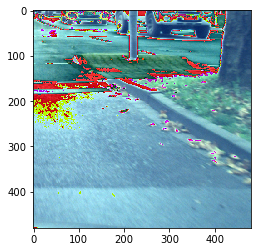

In [106]:
plt.imshow(np.transpose(sample_image[0,0:3], (1, 2, 0)))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33]


(1024, 2048, 3) (1024, 2048)
[ 1  3  4  7  8 11 12 13 17 20 21 23 24 26]
(1024, 2048, 3) (1024, 2048)
[ 0  5  6  7  8 11 12 13 17 21 22 23 24 26]


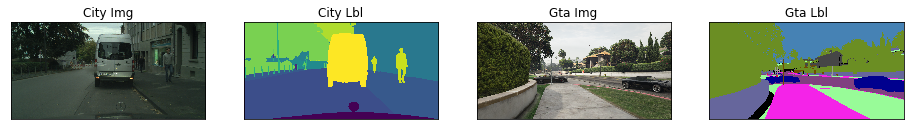

In [154]:
city_img_path = '/data/datasets/citys/leftImg8bit/train/aachen/aachen_000173_000019_leftImg8bit.png'
city_lbl_path = '/data/datasets/citys/gtFine/train/aachen/aachen_000173_000019_gtFine_labelIds.png'

img = Image.open(city_img_path)
lbl = Image.open(city_lbl_path)

city_np_img = np.asarray(img, dtype=np.uint8)
city_np_lbl = np.asarray(lbl, dtype=np.uint8)

print(city_np_img.shape, city_np_lbl.shape)
print(np.unique(city_np_lbl))

city_img = img
city_lbl = lbl

gta_img_path = '/data/datasets/gta/images/09162.png'
gta_lbl_path = '/data/datasets/gta/labels/09162.png'

img = Image.open(gta_img_path)
lbl = Image.open(gta_lbl_path)

img_size = (2048, 1024)
img = img.resize(img_size, Image.BILINEAR)
lbl = lbl.resize(img_size, Image.NEAREST)

gta_np_img = np.asarray(img, dtype=np.uint8)
gta_np_lbl = np.asarray(lbl, dtype=np.uint8)

print(gta_np_img.shape, gta_np_lbl.shape)
print(np.unique(gta_np_lbl))

gta_img = img
gta_lbl = lbl

visualize(city_img=city_img, city_lbl=city_lbl, gta_img=gta_img, gta_lbl=gta_lbl)

In [143]:
valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
_key = np.array([-1, -1, -1, -1, -1, -1,
                  -1, -1, 0, 1, -1, -1,
                  2, 3, 4, -1, -1, -1,
                  5, -1, 6, 7, 8, 9,
                  10, 11, 12, 13, 14, 15,
                  -1, -1, 16, 17, 18])
_mapping = np.array(range(-1, len(_key) - 1)).astype('int32')
print(_mapping)

def _class_to_index(mask):
    # assert the value
    values = np.unique(mask)
    for value in values:
        assert (value in _mapping)
    index = np.digitize(mask.ravel(), _mapping, right=True)
    return _key[index].reshape(mask.shape)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33]


In [144]:
np.unique(_class_to_index(city_np_lbl))

array([-1,  0,  1,  2,  3,  4,  5,  7,  8, 10, 11, 13])

In [145]:
np.unique(_class_to_index(gta_np_lbl))

array([-1,  0,  1,  2,  3,  4,  5,  8,  9, 10, 11, 13])

In [148]:
values = np.unique(gta_np_lbl)
print(values)
for value in values:
    assert (value in _mapping)

[ 0  5  6  7  8 11 12 13 17 21 22 23 24 26]


In [149]:
values

array([ 0,  5,  6,  7,  8, 11, 12, 13, 17, 21, 22, 23, 24, 26],
      dtype=uint8)

In [104]:
img = city_np_img.astype(np.float64)
img -= (0, 0, 0)
img = img.astype(float) / 255.0
img = img.transpose(2, 0, 1)

In [105]:
print(city_np_img.shape)
print(img.shape)

(1024, 2048, 3)
(3, 1024, 2048)


# GTASegmentation

In [116]:
from torchvision import transforms
import torch.utils.data as data

train_dataset = GTASegmentation(split='train', transform=train_transforms)
train_sampler = data.sampler.RandomSampler(train_dataset)
train_batch_sampler = data.sampler.BatchSampler(train_sampler, 4, drop_last=True)


/data/datasets/gta


In [139]:
train_data = data.DataLoader(train_dataset, 1, shuffle=True, num_workers=0, drop_last=True)

# train_data = data.DataLoader(train_dataset, batch_sampler=train_batch_sampler)

sample_gta_image = sample_gta_label = None

for idx, (image, label, base) in enumerate(train_data):
    try:
        print(idx, base)
        sample_gta_image = image
        sample_gta_label = label
    except Exception as e:
        print(e)

0 ('09162.png',)
1 ('14660.png',)


AssertionError: 

In [31]:
print(sample_gta_image.shape, sample_gta_label.shape)

AttributeError: 'NoneType' object has no attribute 'shape'

In [32]:
plt.imshow(np.transpose(sample_gta_image[0,0:3], (1, 2, 0)))

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Copyright (c) Microsoft Corporation.
# Licensed under the MIT License.

"""This module implements an abstract base class (ABC) 'BaseDataset' for datasets.

It also includes common transformation functions (e.g., get_transform, __scale_width), which can be later used in subclasses.
"""
import torch.utils.data as data
from PIL import Image
import torchvision.transforms as transforms
from abc import ABC, abstractmethod


class BaseDataset(data.Dataset, ABC):
    """This class is an abstract base class (ABC) for datasets.

    To create a subclass, you need to implement the following four functions:
    -- <__init__>:                      initialize the class, first call BaseDataset.__init__(self, opt).
    -- <__len__>:                       return the size of dataset.
    -- <__getitem__>:                   get a data point.
    -- <modify_commandline_options>:    (optionally) add dataset-specific options and set default options.
    """

    def __init__(self, opt):
        """Initialize the class; save the options in the class

        Parameters:
            opt (Option class)-- stores all the experiment flags; needs to be a subclass of BaseOptions
        """
        self.opt = opt

    @staticmethod
    def modify_commandline_options(parser, is_train):
        """Add new dataset-specific options, and rewrite default values for existing options.

        Parameters:
            parser          -- original option parser
            is_train (bool) -- whether training phase or test phase. You can use this flag to add training-specific or test-specific options.

        Returns:
            the modified parser.
        """
        return parser

    @abstractmethod
    def __len__(self):
        """Return the total number of images in the dataset."""
        return 0

    @abstractmethod
    def __getitem__(self, index):
        """Return a data point and its metadata information.

        Parameters:
            index - - a random integer for data indexing

        Returns:
            a dictionary of data with their names. It ususally contains the data itself and its metadata information.
        """
        pass


def get_transform(opt, grayscale=False, convert=True, crop=True, flip=True):
    """Create a torchvision transformation function

    The type of transformation is defined by option (e.g., [opt.preprocess], [opt.load_size], [opt.crop_size])
    and can be overwritten by arguments such as [convert], [crop], and [flip]

    Parameters:
        opt (Option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions
        grayscale (bool)   -- if convert input RGB image to a grayscale image
        convert (bool)     -- if convert an image to a tensor array betwen [-1, 1]
        crop    (bool)     -- if apply cropping
        flip    (bool)     -- if apply horizontal flippling
    """
    transform_list = []
    if grayscale:
        transform_list.append(transforms.Grayscale(1))
    if opt.preprocess == 'resize_and_crop':
        osize = [opt.load_size, opt.load_size]
        transform_list.append(transforms.Resize(osize, Image.BICUBIC))
        transform_list.append(transforms.RandomCrop(opt.crop_size))
    elif opt.preprocess == 'crop' and crop:
        transform_list.append(transforms.RandomCrop(opt.crop_size))
    elif opt.preprocess == 'scale_width':
        transform_list.append(transforms.Lambda(lambda img: __scale_width(img, opt.crop_size)))
    elif opt.preprocess == 'scale_width_and_crop':
        transform_list.append(transforms.Lambda(lambda img: __scale_width(img, opt.load_size)))
        if crop:
            transform_list.append(transforms.RandomCrop(opt.crop_size))
    elif opt.preprocess == 'none':
        transform_list.append(transforms.Lambda(lambda img: __adjust(img)))
    else:
        raise ValueError('--preprocess %s is not a valid option.' % opt.preprocess)

    if not opt.no_flip and flip:
        transform_list.append(transforms.RandomHorizontalFlip())
    if convert:
        transform_list += [transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)


def __adjust(img):
    """Modify the width and height to be multiple of 4.

    Parameters:
        img (PIL image) -- input image

    Returns a modified image whose width and height are mulitple of 4.

    the size needs to be a multiple of 4,
    because going through generator network may change img size
    and eventually cause size mismatch error
    """
    ow, oh = img.size
    mult = 4
    if ow % mult == 0 and oh % mult == 0:
        return img
    w = (ow - 1) // mult
    w = (w + 1) * mult
    h = (oh - 1) // mult
    h = (h + 1) * mult

    if ow != w or oh != h:
        __print_size_warning(ow, oh, w, h)

    return img.resize((w, h), Image.BICUBIC)


def __scale_width(img, target_width):
    """Resize images so that the width of the output image is the same as a target width

    Parameters:
        img (PIL image)    -- input image
        target_width (int) -- target image width

    Returns a modified image whose width matches the target image width;

    the size needs to be a multiple of 4,
    because going through generator network may change img size
    and eventually cause size mismatch error
    """
    ow, oh = img.size

    mult = 4
    assert target_width % mult == 0, "the target width needs to be multiple of %d." % mult
    if (ow == target_width and oh % mult == 0):
        return img
    w = target_width
    target_height = int(target_width * oh / ow)
    m = (target_height - 1) // mult
    h = (m + 1) * mult

    if target_height != h:
        __print_size_warning(target_width, target_height, w, h)

    return img.resize((w, h), Image.BICUBIC)


def __print_size_warning(ow, oh, w, h):
    """Print warning information about image size(only print once)"""
    if not hasattr(__print_size_warning, 'has_printed'):
        print("The image size needs to be a multiple of 4. "
              "The loaded image size was (%d, %d), so it was adjusted to "
              "(%d, %d). This adjustment will be done to all images "
              "whose sizes are not multiples of 4" % (ow, oh, w, h))
        __print_size_warning.has_printed = True

        # Copyright (c) Microsoft Corporation.
# Licensed under the MIT License.
# Adapted from https://github.com/ZijunDeng/pytorch-semantic-segmentation/blob/master/utils/joint_transforms.py

import math
import numbers
import random
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as tf

from PIL import Image, ImageOps


class Compose(object):
    def __init__(self, augmentations):
        self.augmentations = augmentations
        self.PIL2Numpy = False

    def __call__(self, img, mask, mask1=None, lpsoft=None):
        params = {}
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img, mode="RGB")
            mask = Image.fromarray(mask, mode="L")
            if mask1 is not None:
                mask1 = Image.fromarray(mask1, mode="L")
            if lpsoft is not None:
                lpsoft = torch.from_numpy(lpsoft)
                lpsoft = F.interpolate(lpsoft.unsqueeze(0), size=[img.size[1], img.size[0]], mode='bilinear', align_corners=True)[0]
            self.PIL2Numpy = True

        if img.size != mask.size:
            print (img.size, mask.size)
        assert img.size == mask.size
        if mask1 is not None:
            assert (img.size == mask1.size)
        for a in self.augmentations:
            img, mask, mask1, lpsoft, params = a(img, mask, mask1, lpsoft, params)
            # print(img.size)

        if self.PIL2Numpy:
            img, mask = np.array(img), np.array(mask, dtype=np.uint8) 
            if mask1 is not None:
                mask1 = np.array(mask1, dtype=np.uint8)
        return img, mask, mask1, lpsoft, params


class RandomCrop(object):
    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    def __call__(self, img, mask, mask1=None, lpsoft=None, params=None):
        if self.padding > 0:
            img = ImageOps.expand(img, border=self.padding, fill=0)
            mask = ImageOps.expand(mask, border=self.padding, fill=0)
            if mask1 is not None:
                mask1 = ImageOps.expand(mask1, border=self.padding, fill=0)

        assert img.size == mask.size
        if mask1 is not None:
            assert (img.size == mask1.size)
        w, h = img.size
        tw, th = self.size
        if w == tw and h == th:
            return img, mask
        if w < tw or h < th:
            if lpsoft is not None:
                lpsoft = F.interpolate(lpsoft.unsqueeze(0), size=[th, tw], mode='bolinear', align_corners=True)[0]
            if mask1 is not None:
                return (
                        img.resize((tw, th), Image.BILINEAR),
                        mask.resize((tw, th), Image.NEAREST),
                        mask1.resize((tw, th), Image.NEAREST),
                        lpsoft
                    )
            else:
                    return (
                        img.resize((tw, th), Image.BILINEAR),
                        mask.resize((tw, th), Image.NEAREST),
                        None,
                        lpsoft
                    )

        x1 = random.randint(0, w - tw)
        y1 = random.randint(0, h - th)
        params['RandomCrop'] = (y1, y1 + th, x1, x1 + tw)
        if lpsoft is not None:
            lpsoft = lpsoft[:, y1:y1 + th, x1:x1 + tw]
        if mask1 is not None:
            return (
                img.crop((x1, y1, x1 + tw, y1 + th)),
                mask.crop((x1, y1, x1 + tw, y1 + th)),
                mask1.crop((x1, y1, x1 + tw, y1 + th)),
                lpsoft,
                params
            )
        else:
            return (
                img.crop((x1, y1, x1 + tw, y1 + th)),
                mask.crop((x1, y1, x1 + tw, y1 + th)),
                None,
                lpsoft,
                params
            )


class AdjustGamma(object):
    def __init__(self, gamma):
        self.gamma = gamma

    def __call__(self, img, mask):
        assert img.size == mask.size
        return tf.adjust_gamma(img, random.uniform(1, 1 + self.gamma)), mask


class AdjustSaturation(object):
    def __init__(self, saturation):
        self.saturation = saturation

    def __call__(self, img, mask):
        assert img.size == mask.size
        return tf.adjust_saturation(img, 
                                    random.uniform(1 - self.saturation, 
                                                   1 + self.saturation)), mask


class AdjustHue(object):
    def __init__(self, hue):
        self.hue = hue

    def __call__(self, img, mask):
        assert img.size == mask.size
        return tf.adjust_hue(img, random.uniform(-self.hue, 
                                                  self.hue)), mask


class AdjustBrightness(object):
    def __init__(self, bf):
        self.bf = bf

    def __call__(self, img, mask):
        assert img.size == mask.size
        return tf.adjust_brightness(img, 
                                    random.uniform(1 - self.bf, 
                                                   1 + self.bf)), mask

class AdjustContrast(object):
    def __init__(self, cf):
        self.cf = cf

    def __call__(self, img, mask):
        assert img.size == mask.size
        return tf.adjust_contrast(img, 
                                  random.uniform(1 - self.cf, 
                                                 1 + self.cf)), mask

class CenterCrop(object):
    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, img, mask):
        assert img.size == mask.size
        w, h = img.size
        th, tw = self.size
        x1 = int(round((w - tw) / 2.))
        y1 = int(round((h - th) / 2.))
        return (
            img.crop((x1, y1, x1 + tw, y1 + th)),
            mask.crop((x1, y1, x1 + tw, y1 + th)),
        )


class RandomHorizontallyFlip(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img, mask, mask1=None, lpsoft=None, params=None):
        if random.random() < self.p:
            params['RandomHorizontallyFlip'] = True
            if lpsoft is not None:
                inv_idx = torch.arange(lpsoft.size(2)-1,-1,-1).long()  # C x H x W
                lpsoft = lpsoft.index_select(2,inv_idx)
            if mask1 is not None:
                return (
                    img.transpose(Image.FLIP_LEFT_RIGHT),
                    mask.transpose(Image.FLIP_LEFT_RIGHT),
                    mask1.transpose(Image.FLIP_LEFT_RIGHT),
                    lpsoft,
                    params
                )
            else:
                return (
                    img.transpose(Image.FLIP_LEFT_RIGHT),
                    mask.transpose(Image.FLIP_LEFT_RIGHT),
                    None,
                    lpsoft,
                    params
                )
        else:
            params['RandomHorizontallyFlip'] = False
        return img, mask, mask1, lpsoft, params


class RandomVerticallyFlip(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img, mask):
        if random.random() < self.p:
            return (
                img.transpose(Image.FLIP_TOP_BOTTOM),
                mask.transpose(Image.FLIP_TOP_BOTTOM),
            )
        return img, mask


class FreeScale(object):
    def __init__(self, size):
        self.size = tuple(reversed(size))  # size: (h, w)

    def __call__(self, img, mask):
        assert img.size == mask.size
        return (
            img.resize(self.size, Image.BILINEAR),
            mask.resize(self.size, Image.NEAREST),
        )


class RandomTranslate(object):
    def __init__(self, offset):
        self.offset = offset # tuple (delta_x, delta_y)

    def __call__(self, img, mask):
        assert img.size == mask.size
        x_offset = int(2 * (random.random() - 0.5) * self.offset[0])
        y_offset = int(2 * (random.random() - 0.5) * self.offset[1])
        
        x_crop_offset = x_offset
        y_crop_offset = y_offset
        if x_offset < 0:
            x_crop_offset = 0
        if y_offset < 0:
            y_crop_offset = 0
        
        cropped_img = tf.crop(img, 
                              y_crop_offset, 
                              x_crop_offset, 
                              img.size[1]-abs(y_offset), 
                              img.size[0]-abs(x_offset))

        if x_offset >= 0 and y_offset >= 0:
            padding_tuple = (0, 0, x_offset, y_offset)

        elif x_offset >= 0 and y_offset < 0:
            padding_tuple = (0, abs(y_offset), x_offset, 0)
        
        elif x_offset < 0 and y_offset >= 0:
            padding_tuple = (abs(x_offset), 0, 0, y_offset)
        
        elif x_offset < 0 and y_offset < 0:
            padding_tuple = (abs(x_offset), abs(y_offset), 0, 0)
        
        return (
              tf.pad(cropped_img, 
                     padding_tuple, 
                     padding_mode='reflect'),
              tf.affine(mask,
                        translate=(-x_offset, -y_offset),
                        scale=1.0,
                        angle=0.0,
                        shear=0.0,
                        fillcolor=250))


class RandomRotate(object):
    def __init__(self, degree):
        self.degree = degree

    def __call__(self, img, mask):
        rotate_degree = random.random() * 2 * self.degree - self.degree
        return (
            tf.affine(img, 
                      translate=(0, 0),
                      scale=1.0, 
                      angle=rotate_degree, 
                      resample=Image.BILINEAR,
                      fillcolor=(0, 0, 0),
                      shear=0.0),
            tf.affine(mask, 
                      translate=(0, 0), 
                      scale=1.0, 
                      angle=rotate_degree, 
                      resample=Image.NEAREST,
                      fillcolor=250,
                      shear=0.0))



class Scale(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img, mask):
        assert img.size == mask.size
        w, h = img.size
        if (w >= h and w == self.size) or (h >= w and h == self.size):
            return img, mask
        if w > h:
            ow = self.size
            oh = int(self.size * h / w)
            return (
                img.resize((ow, oh), Image.BILINEAR),
                mask.resize((ow, oh), Image.NEAREST),
            )
        else:
            oh = self.size
            ow = int(self.size * w / h)
            return (
                img.resize((ow, oh), Image.BILINEAR),
                mask.resize((ow, oh), Image.NEAREST),
            )

def MyScale(img, lbl, size):
    """scale

    img, lbl, longer size
    """
    if isinstance(img, np.ndarray):
        _img = Image.fromarray(img)
        _lbl = Image.fromarray(lbl)
    else:
        _img = img
        _lbl = lbl
    assert _img.size == _lbl.size
    # prop = 1.0 * _img.size[0]/_img.size[1]
    w, h = size
    # h = int(size / prop)
    _img = _img.resize((w, h), Image.BILINEAR)
    _lbl = _lbl.resize((w, h), Image.NEAREST)
    return np.array(_img), np.array(_lbl)

def Flip(img, lbl, prop):
    """
    flip img and lbl with probablity prop
    """
    if isinstance(img, np.ndarray):
        _img = Image.fromarray(img)
        _lbl = Image.fromarray(lbl)
    else:
        _img = img
        _lbl = lbl
    if random.random() < prop:
        _img.transpose(Image.FLIP_LEFT_RIGHT),
        _lbl.transpose(Image.FLIP_LEFT_RIGHT),
    return np.array(_img), np.array(_lbl)

def MyRotate(img, lbl, degree):
    """
    img, lbl, degree
    randomly rotate clockwise or anti-clockwise
    """
    if isinstance(img, np.ndarray):
        _img = Image.fromarray(img)
        _lbl = Image.fromarray(lbl)
    else:
        _img = img
        _lbl = lbl
    _degree = random.random()*degree
    
    flags = -1
    if random.random() < 0.5:
        flags = 1
    _img = _img.rotate(_degree * flags)
    _lbl = _lbl.rotate(_degree * flags)
    return np.array(_img), np.array(_lbl)

class RandomSizedCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img, mask):
        assert img.size == mask.size
        for attempt in range(10):
            area = img.size[0] * img.size[1]
            target_area = random.uniform(0.45, 1.0) * area
            aspect_ratio = random.uniform(0.5, 2)

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if random.random() < 0.5:
                w, h = h, w

            if w <= img.size[0] and h <= img.size[1]:
                x1 = random.randint(0, img.size[0] - w)
                y1 = random.randint(0, img.size[1] - h)

                img = img.crop((x1, y1, x1 + w, y1 + h))
                mask = mask.crop((x1, y1, x1 + w, y1 + h))
                assert img.size == (w, h)

                return (
                    img.resize((self.size, self.size), Image.BILINEAR),
                    mask.resize((self.size, self.size), Image.NEAREST),
                )

        # Fallback
        scale = Scale(self.size)
        crop = CenterCrop(self.size)
        return crop(*scale(img, mask))


class RandomSized(object):
    def __init__(self, size):
        self.size = size
        self.scale = Scale(self.size)
        self.crop = RandomCrop(self.size)

    def __call__(self, img, mask, mask1=None, lpsoft=None, params=None):
        assert img.size == mask.size
        if mask1 is not None:
            assert (img.size == mask1.size)

        prop = 1.0 * img.size[0] / img.size[1]
        w = int(random.uniform(0.5, 1.5) * self.size)
        #w = self.size
        h = int(w/prop)
        params['RandomSized'] = (h, w)
        # h = int(random.uniform(0.5, 2) * self.size[1])

        img, mask = (
            img.resize((w, h), Image.BILINEAR),
            mask.resize((w, h), Image.NEAREST),
        )
        if mask1 is not None:
            mask1 = mask1.resize((w, h), Image.NEAREST)
        if lpsoft is not None:
            lpsoft = F.interpolate(lpsoft.unsqueeze(0), size=[h, w], mode='bilinear', align_corners=True)[0]

        return img, mask, mask1, lpsoft, params
        # return self.crop(*self.scale(img, mask))
# Copyright (c) Microsoft Corporation.
# Licensed under the MIT License.

import random

import numpy as np
import PIL
import PIL.ImageOps
import PIL.ImageEnhance
import PIL.ImageDraw
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

PARAMETER_MAX = 10

def AutoContrast(img, **kwarg):
    return PIL.ImageOps.autocontrast(img), None


def Brightness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Brightness(img).enhance(v), v


def Color(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Color(img).enhance(v), v


def Contrast(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Contrast(img).enhance(v), v


def Cutout(img, v, max_v, bias=0):
    if v == 0:
        return img
    v = _float_parameter(v, max_v) + bias
    v = int(v * min(img.size))
    return CutoutAbs(img, v)


def CutoutAbs(img, v, **kwarg):
    w, h = img.size
    x0 = np.random.uniform(0, w)
    y0 = np.random.uniform(0, h)
    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = int(min(w, x0 + v))
    y1 = int(min(h, y0 + v))
    xy = (x0, y0, x1, y1)
    # gray
    color = (127, 127, 127)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img, xy


def Equalize(img, **kwarg):
    return PIL.ImageOps.equalize(img), None


def Identity(img, **kwarg):
    return img, None


def Invert(img, **kwarg):
    return PIL.ImageOps.invert(img), None


def Posterize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.posterize(img, v), v


# def Rotate(img, v, max_v, bias=0):
#     v = _int_parameter(v, max_v) + bias
#     if random.random() < 0.5:
#         v = -v
#     #return img.rotate(v), v
#     img_t = transforms.ToTensor()(img)
#     H = img_t.shape[1]
#     W = img_t.shape[2]
#     theta = np.array([[np.cos(v/180*np.pi), -np.sin(v/180*np.pi), 0], [np.sin(v/180*np.pi), np.cos(v/180*np.pi), 0]]).astype(np.float)
#     theta[0,1] = theta[0,1]*H/W
#     theta[1,0] = theta[1,0]*W/H
#     #theta = np.array([[np.cos(v/180*np.pi), -np.sin(v/180*np.pi)], [np.sin(v/180*np.pi), np.cos(v/180*np.pi)]]).astype(np.float)
#     theta = torch.Tensor(theta).unsqueeze(0)

#     # meshgrid_x, meshgrid_y = torch.meshgrid(torch.arange(W, dtype=torch.float), torch.arange(H, dtype=torch.float))
#     # meshgrid = torch.stack((meshgrid_x.t()*2/W - 1, meshgrid_y.t()*2/H - 1), dim=-1).unsqueeze(0)
#     # grid = torch.matmul(meshgrid, theta)

#     # s_h = int(abs(H - W) // 2)
#     # dim_last = s_h if H > W else 0
#     # img_t = F.pad(img_t.unsqueeze(0), (dim_last, dim_last, s_h - dim_last, s_h - dim_last)).squeeze(0)
#     grid = F.affine_grid(theta, img_t.unsqueeze(0).size())
#     img_t = F.grid_sample(img_t.unsqueeze(0), grid, mode='bilinear').squeeze(0)
#     # img_t = img_t[:,:,s_h:-s_h] if H > W else img_t[:,s_h:-s_h,:]
#     img_t = transforms.ToPILImage()(img_t)
#     return img_t, v

def Rotate(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.rotate(v, resample=Image.BILINEAR, fillcolor=(127,127,127)), v

def Sharpness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Sharpness(img).enhance(v), v


def ShearX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0), resample=Image.BILINEAR, fillcolor=(127,127,127)), v


def ShearY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0), resample=Image.BILINEAR, fillcolor=(127,127,127)), v


def Solarize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.solarize(img, 256 - v), 256 - v


def SolarizeAdd(img, v, max_v, bias=0, threshold=128):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    img_np = np.array(img).astype(np.int)
    img_np = img_np + v
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold), threshold


def TranslateX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[0])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0), resample=Image.BILINEAR, fillcolor=(127,127,127)), v


def TranslateY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[1])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v), resample=Image.BILINEAR, fillcolor=(127,127,127)), v


def _float_parameter(v, max_v):
    return float(v) * max_v / PARAMETER_MAX


def _int_parameter(v, max_v):
    return int(v * max_v / PARAMETER_MAX)


def fixmatch_augment_pool():
    # FixMatch paper
    augs = [(AutoContrast, None, None),
            (Brightness, 0.9, 0.05),
            (Color, 0.9, 0.05),
            (Contrast, 0.9, 0.05),
            (Equalize, None, None),
            (Identity, None, None),
            (Posterize, 4, 4),
            (Rotate, 30, 0),
            (Sharpness, 0.9, 0.05),
            (ShearX, 0.3, 0),
            (ShearY, 0.3, 0),
            (Solarize, 256, 0),
            (TranslateX, 0.3, 0),
            (TranslateY, 0.3, 0)]
    return augs


def my_augment_pool():
    # Test
    augs = [(AutoContrast, None, None),
            (Brightness, 1.8, 0.1),
            (Color, 1.8, 0.1),
            (Contrast, 1.8, 0.1),
            (Cutout, 0.2, 0),
            (Equalize, None, None),
            (Invert, None, None),
            (Posterize, 4, 4),
            (Rotate, 30, 0),
            (Sharpness, 1.8, 0.1),
            (ShearX, 0.3, 0),
            (ShearY, 0.3, 0),
            (Solarize, 256, 0),
            (SolarizeAdd, 110, 0),
            (TranslateX, 0.45, 0),
            (TranslateY, 0.45, 0)]
    return augs


class RandAugmentPC(object):
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        self.n = n
        self.m = m
        self.augment_pool = my_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            prob = np.random.uniform(0.2, 0.8)
            if random.random() + prob >= 1:
                img = op(img, v=self.m, max_v=max_v, bias=bias)
        img = CutoutAbs(img, 16)
        return img


class RandAugmentMC(object):
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        self.n = n
        self.m = m
        self.augment_pool = fixmatch_augment_pool()

    def __call__(self, img, type='crc'):
        aug_type = {'Hflip':False, 'ShearX':1e4, 'ShearY':1e4, 'TranslateX':1e4, 'TranslateY':1e4, 'Rotate':1e4, 'CutoutAbs':1e4}
        if random.random() < 0.5:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            #aug_type.append(['Hflip', True])
            aug_type['Hflip'] = True
        if type == 'cr' or type == 'crc':
            ops = random.choices(self.augment_pool, k=self.n)
            for op, max_v, bias in ops:
                v = np.random.randint(1, self.m)
                if random.random() < 0.5:
                    img, params = op(img, v=v, max_v=max_v, bias=bias)
                    if op.__name__ in ['ShearX', 'ShearY', 'TranslateX', 'TranslateY', 'Rotate']:
                        #aug_type.append([op.__name__, params])
                        aug_type[op.__name__] = params
        if type == 'cc' or type == 'crc':
            img, params = CutoutAbs(img, min(img.size[0], img.size[1]) // 3)
            #aug_type.append([CutoutAbs.__name__, params])
            aug_type['CutoutAbs'] = params
        return img, aug_type

def affine_sample(tensor, v, type):
    # tensor: B*C*H*W
    # v: scalar, translation param
    if type == 'Rotate':
        theta = np.array([[np.cos(v/180*np.pi), -np.sin(v/180*np.pi), 0], [np.sin(v/180*np.pi), np.cos(v/180*np.pi), 0]]).astype(np.float)
    elif type == 'ShearX':
        theta = np.array([[1, v, 0], [0, 1, 0]]).astype(np.float)
    elif type == 'ShearY':
        theta = np.array([[1, 0, 0], [v, 1, 0]]).astype(np.float)
    elif type == 'TranslateX':
        theta = np.array([[1, 0, v], [0, 1, 0]]).astype(np.float)
    elif type == 'TranslateY':
        theta = np.array([[1, 0, 0], [0, 1, v]]).astype(np.float)

    H = tensor.shape[2]
    W = tensor.shape[3]
    theta[0,1] = theta[0,1]*H/W
    theta[1,0] = theta[1,0]*W/H
    if type != 'Rotate':
        theta[0,2] = theta[0,2]*2/H + theta[0,0] + theta[0,1] - 1
        theta[1,2] = theta[1,2]*2/H + theta[1,0] + theta[1,1] - 1

    theta = torch.Tensor(theta).unsqueeze(0)
    grid = F.affine_grid(theta, tensor.size()).to(tensor.device)
    tensor_t = F.grid_sample(tensor, grid, mode='nearest')
    return tensor_t

if __name__ == '__main__':
    randaug = RandAugmentMC(2, 10)
    #path = r'E:\WorkHome\IMG_20190131_142431.jpg'
    path = r'E:\WorkHome\0.png'
    img = Image.open(path)
    img_t = transforms.ToTensor()(img).unsqueeze(0)
    #img_aug, aug_type = randaug(img)
    #img_aug.show()
    
    # v = 20
    # img_pil = img.rotate(v)
    # img_T = affine_sample(img_t, v, 'Rotate')

    v = 0.12
    img_pil = img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))
    img_T = affine_sample(img_t, v, 'ShearY')

    img_ten = transforms.ToPILImage()(img_T.squeeze(0))
    img_pil.show()
    img_ten.show()

In [ ]:
import os
import sys
import torch
import numpy as np
import scipy.misc as m
import matplotlib.pyplot as plt
import matplotlib.image  as imgs
from PIL import Image
import random
import scipy.io as io
from tqdm import tqdm
from scipy import stats

from torch.utils import data


class GTA5_loader(BaseDataset):
    """
    GTA5    synthetic dataset
    for domain adaptation to Cityscapes
    """

    colors = [  # [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

    label_colours = dict(zip(range(19), colors))
    def __init__(self, opt, logger, augmentations=None):
        self.opt = opt
        self.root = opt.src_rootpath
        self.split = 'all'
        self.augmentations = augmentations
        self.randaug = RandAugmentMC(2, 10)
        self.n_classes = 19
        self.img_size = (1914, 1052)

        self.mean = [0.0, 0.0, 0.0] #TODO:  calculating the mean value of rgb channels on GTA5
        self.image_base_path = os.path.join(self.root, 'images')
        self.label_base_path = os.path.join(self.root, 'labels')
        splits = io.loadmat(os.path.join(self.root, 'split.mat'))
        if self.split == 'all':
            ids = np.concatenate((splits['trainIds'][:,0], splits['valIds'][:,0], splits['testIds'][:,0]))
        elif self.split == 'train':
            ids = splits['trainIds'][:,0]
        elif self.split == 'val':
            ids = splits['valIds'][:200,0]
        elif self.split == 'test':
            ids = splits['testIds'][:,0]
        self.ids = []
        for i in range(len(ids)):
            self.ids.append(os.path.join(self.label_base_path, str(i+1).zfill(5) + '.png'))


        self.void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, 34, -1]
        self.valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33,]
        self.class_names = ["unlabelled","road","sidewalk","building","wall","fence","pole","traffic_light",
            "traffic_sign","vegetation","terrain","sky","person","rider","car","truck","bus","train",
            "motorcycle","bicycle",]

        self.ignore_index = 250
        self.class_map = dict(zip(self.valid_classes, range(19)))

        if len(self.ids) == 0:
            raise Exception(
                "No files for style=[%s] found in %s" % (self.split, self.image_base_path)
            )
        
        print("Found {} {} images".format(len(self.ids), self.split))

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        """__getitem__
        
        param: index
        """
        id = self.ids[index]
        if self.split != 'all' and self.split != 'val':
            filename = '{:05d}.png'.format(id)
            img_path = os.path.join(self.image_base_path, filename)
            lbl_path = os.path.join(self.label_base_path, filename)
        else:
            img_path = os.path.join(self.image_base_path, id.split('/')[-1])
            lbl_path = id
        
        img = Image.open(img_path)
        lbl = Image.open(lbl_path)

        img = img.resize(self.img_size, Image.BILINEAR)
        lbl = lbl.resize(self.img_size, Image.NEAREST)
        img = np.asarray(img, dtype=np.uint8)
        lbl = np.asarray(lbl, dtype=np.uint8)

        lbl = self.encode_segmap(np.array(lbl, dtype=np.uint8))

        input_dict = {}        
        if self.augmentations!=None:
            img, lbl, _, _, _ = self.augmentations(img, lbl)
            img_strong, params = self.randaug(Image.fromarray(img))
            img_strong, _ = self.transform(img_strong, lbl)
            input_dict['img_strong'] = img_strong
            input_dict['params'] = params

        img, lbl = self.transform(img, lbl)

        input_dict['img'] = img
        input_dict['label'] = lbl
        input_dict['img_path'] = self.ids[index]
        return input_dict


    def encode_segmap(self, lbl):
        for _i in self.void_classes:
            lbl[lbl == _i] = self.ignore_index
        for _i in self.valid_classes:
            lbl[lbl == _i] = self.class_map[_i]
        return lbl

    def decode_segmap(self, temp):
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = self.label_colours[l][0]
            g[temp == l] = self.label_colours[l][1]
            b[temp == l] = self.label_colours[l][2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb

    def transform(self, img, lbl):
        """transform

        img, lbl
        """
        img = np.array(img)
        # img = img[:, :, ::-1] # RGB -> BGR
        img = img.astype(np.float64)
        img -= self.mean
        img = img.astype(float) / 255.0
        img = img.transpose(2, 0, 1)

        classes = np.unique(lbl)
        lbl = np.array(lbl)
        lbl = lbl.astype(float)
        # lbl = m.imresize(lbl, self.img_size, "nearest", mode='F')
        lbl = lbl.astype(int)
        
        if not np.all(classes == np.unique(lbl)):
            print("WARN: resizing labels yielded fewer classes")    #TODO: compare the original and processed ones

        if not np.all(np.unique(lbl[lbl != self.ignore_index]) < self.n_classes): 
            print("after det", classes, np.unique(lbl))
            raise ValueError("Segmentation map contained invalid class values")
        
        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()

        return img, lbl

    def get_cls_num_list(self):
        cls_num_list = np.array([16139327127,  4158369631,  8495419275,   927064742,   318109335,
                                532432540,    67453231,    40526481,  3818867486,  1081467674,
                                6800402117,   182228033,    15360044,  1265024472,   567736474,
                                184854135,    32542442,    15832619,     2721193])
        # cls_num_list = np.zeros(self.n_classes, dtype=np.int64)
        # for n in range(len(self.ids)):
        #     lbl = Image.open(self.ids[n])
        #     lbl = lbl.resize(self.img_size, Image.NEAREST)
        #     lbl = np.asarray(lbl, dtype=np.uint8)
        #     lbl = self.encode_segmap(np.array(lbl, dtype=np.uint8))
        #     for i in range(self.n_classes):
        #         cls_num_list[i] += (lbl == i).sum()
        return cls_num_list


In [ ]:
class Opt:
    src_rootpath = "/data/datasets/gta"
    model_name = 'deeplabv2'
    split = 'train'
    
opt = Opt()

In [ ]:
train_dataset = GTA5_loader(opt=opt, logger=None)
train_sampler = data.sampler.RandomSampler(train_dataset)
train_batch_sampler = data.sampler.BatchSampler(train_sampler, 4, drop_last=True)

train_data = data.DataLoader(train_dataset, 4, shuffle=True, num_workers=16, drop_last=True)

# train_data = data.DataLoader(train_dataset, batch_sampler=train_batch_sampler)


In [ ]:
train_dataset.class_map

In [ ]:
sample_gta_image = sample_gta_label = None

for idx, data in enumerate(train_data):
    try:
        sample_gta_image = image
        sample_gta_label = label
        break

    except Exception as e:
        print(idx)
        print(e)

In [ ]:
sample_gta_image = data['img']
sample_gta_label = data['label']
sample_gta_path = data['img_path']

In [ ]:
print(sample_gta_image.shape, sample_gta_label.shape)

In [ ]:
plt.imshow(np.transpose(sample_gta_image[0,0:3], (1, 2, 0)))